In [1]:
import fastbook

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
# from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

from utils.all import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

curPath = getCurDir()

modelPath = getModelPath(curPath)

In [2]:
dataPath = getDatasetPath(curPath)

dataPath.ls(file_type='text')

(#3) [Path('/media/jimbeam/DATA/Project/unpackAI/assignment/Prudential Life Insurance Assessment/prudential-life-insurance-assessment/sample_submission.csv'),Path('/media/jimbeam/DATA/Project/unpackAI/assignment/Prudential Life Insurance Assessment/prudential-life-insurance-assessment/test.csv'),Path('/media/jimbeam/DATA/Project/unpackAI/assignment/Prudential Life Insurance Assessment/prudential-life-insurance-assessment/train.csv')]

In [3]:
df_all = pd.read_csv(dataPath/'train.csv', low_memory = False)
df_test = pd.read_csv(dataPath/'test.csv', low_memory = False)

df_all.columns

Index(['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3',
       'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7',
       'Ins_Age', 'Ht',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=128)

In [4]:
dep_var = 'Response'

Based on the insurance industry knowledge, we know that these are high risk policies:

1. Old Age
1. Obese persons
1. High BMI
1. Extremely short or tall persons

We will therefore create few features such as:

1. Person very old or very young or in middle
1. Person very short or tall or in middle
1. Person with very high BMI or low BMI or in middle
1. Persons with obesity or are very thin or in middle

We will also create few more features such as:

1. Multiplication of BMI and Age - higher the factor, higher the risk
1. Multiplication of Weight and Age - higher the factor, higher the risk
1. Multiplication of Height and Age
1. Split of Product Info 2 into numericals and characters
1. Few stats description of Medical Keywords
1. Depending on the BMI, classification of lives into High Risk or Low Risk (very low and very high BMI both are risky factors)
1. Depending on BMI, Ht, Wt, Age, creation of more features which basically categorizes the risk into different buckets

In [5]:
#1
df_all['Product_Info_2_char'] = df_all.Product_Info_2.str[0]
#2
df_all['Product_Info_2_num'] = df_all.Product_Info_2.str[1]

#3
df_all['BMI_Age'] = df_all['BMI'] * df_all['Ins_Age']
#4
df_all['Age_Wt'] = df_all['Ins_Age'] * df_all['Wt']
#5
df_all['Age_Ht'] = df_all['Ins_Age'] * df_all['Ht']

med_keyword_columns = df_all.columns[df_all.columns.str.startswith('Medical_Keyword_')]
#6
df_all['Med_Keywords_Count'] = df_all[med_keyword_columns].sum(axis=1)

#7
df_all['Ins_Age_sq'] = df_all['Ins_Age'] * df_all['Ins_Age']
#8
df_all['Ht_sq'] = df_all['Ht'] * df_all['Ht']
#9
df_all['Wt_sq'] = df_all['Wt'] * df_all['Wt']
#10
df_all['BMI_sq'] = df_all['BMI'] * df_all['BMI']

#11
df_all['Ins_Age_cu'] = df_all['Ins_Age'] * df_all['Ins_Age'] * df_all['Ins_Age']
#12
df_all['Ht_cu'] = df_all['Ht'] * df_all['Ht'] * df_all['Ht']
#13
df_all['Wt_cu'] = df_all['Wt'] * df_all['Wt'] * df_all['Wt']
#14
df_all['BMI_cu'] = df_all['BMI'] * df_all['BMI'] * df_all['BMI']

# BMI Categorization
conditions = [
    (df_all['BMI'] <= df_all['BMI'].quantile(0.25)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.25)) & (df_all['BMI'] <= df_all['BMI'].quantile(0.75)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']
#15
df_all['BMI_Wt'] = np.select(conditions, choices)

# Age Categorization
conditions = [
    (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.25)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.25)) & (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.75)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.75))]

choices = ['young', 'average', 'old']
#16
df_all['Old_Young'] = np.select(conditions, choices)

# Height Categorization
conditions = [
    (df_all['Ht'] <= df_all['Ht'].quantile(0.25)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.25)) & (df_all['Ht'] <= df_all['Ht'].quantile(0.75)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']
#17
df_all['Short_Tall'] = np.select(conditions, choices)

# Weight Categorization
conditions = [
    (df_all['Wt'] <= df_all['Wt'].quantile(0.25)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.25)) & (df_all['Wt'] <= df_all['Wt'].quantile(0.75)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']
#18
df_all['Thin_Fat'] = np.select(conditions, choices)

#19
df_all['min'] = df_all[med_keyword_columns].min(axis=1)
#20
df_all['max'] = df_all[med_keyword_columns].max(axis=1)
#21
df_all['mean'] = df_all[med_keyword_columns].mean(axis=1)
#22
df_all['std'] = df_all[med_keyword_columns].std(axis=1)
#23
df_all['skew'] = df_all[med_keyword_columns].skew(axis=1)
#24
df_all['kurt'] = df_all[med_keyword_columns].kurtosis(axis=1)
#25
df_all['med'] = df_all[med_keyword_columns].median(axis=1)

In [6]:
df_all['extreme_risk'] = df_all.apply(isExtremelyRisky,axis=1)

In [7]:
df_all.extreme_risk.value_counts()

not_extremely_risky    31732
extremely_risky        27649
Name: extreme_risk, dtype: int64

In [8]:
conditions = [
    (df_all['BMI_Wt'] == 'overweight') ,
    (df_all['BMI_Wt'] == 'average') ,
    (df_all['BMI_Wt'] == 'under_weight') ]

choices = ['risk', 'non-risk', 'risk']
#27
df_all['risk_bmi'] = np.select(conditions, choices)

In [9]:
df_all.risk_bmi.value_counts()

non-risk    29717
risk        29664
Name: risk_bmi, dtype: int64

In [10]:
df_all['average_risk'] = df_all.apply(isAverage,axis=1)

df_all.average_risk.value_counts()

average        53635
non_average     5746
Name: average_risk, dtype: int64

In [11]:
df_all['low_end_risk'] = df_all.apply(isLowEnd,axis=1)

df_all.low_end_risk.value_counts()

low_end        33493
non_low_end    25888
Name: low_end_risk, dtype: int64

In [12]:
df_all['high_end_risk'] = df_all.apply(isHighEnd,axis=1)

df_all.high_end_risk.value_counts()

high_end        31919
non_high_end    27462
Name: high_end_risk, dtype: int64

In [13]:
df_all.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,...,risk_bmi,average_risk,low_end_risk,high_end_risk
0,2,1,D3,10,...,risk,non_average,low_end,high_end
1,5,1,A1,26,...,risk,non_average,low_end,non_high_end
2,6,1,E1,26,...,non-risk,average,low_end,non_high_end
3,7,1,D4,10,...,risk,average,low_end,non_high_end
4,8,1,D2,26,...,non-risk,average,low_end,non_high_end


In [14]:
df_all.drop(['Id'], axis=1, inplace=True)

exclude = ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 
           'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 
           'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 
           'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 
           'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 
           'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 
           'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 
           'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
           'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 
           'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 
           'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41', 
           'Response', 'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Wt', 'Old_Young', 'Thin_Fat', 'Short_Tall', 'risk_bmi',
          'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4',
          'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8',
          'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12',
          'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16',
          'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20',
          'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25',
          'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29',
          'Medical_Keyword_30', 'Medical_Keyword_31', 'Medical_Keyword_32', 'Medical_Keyword_33',
          'Medical_Keyword_34', 'Medical_Keyword_35', 'Medical_Keyword_36', 'Medical_Keyword_37',
          'Medical_Keyword_38', 'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41', 
          'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44',
          'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48', 'extreme_risk', 
           'average_risk', 'high_end_risk', 'low_end_risk']

norm_data = normalize(df_all, exclude=exclude)

In [15]:
df_all.shape

(59381, 157)

In [16]:
df_all.describe()

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,...,std,skew,kurt,med
count,59381.000000,59381.000000,5.938100e+04,59381.000000,...,5.938100e+04,5.938100e+04,5.938100e+04,59381.0
mean,1.026355,24.415655,-1.688565e-16,2.006955,...,-3.401884e-16,-4.258338e-17,5.351585e-16,0.0
std,0.160191,5.072885,9.617004e-01,0.083107,...,9.617004e-01,9.617004e-01,9.617004e-01,0.0
min,1.000000,1.000000,-2.575829e+00,2.000000,...,-2.575829e+00,-2.575829e+00,-2.575829e+00,0.0
25%,1.000000,26.000000,-6.666433e-01,2.000000,...,-6.666433e-01,-6.666433e-01,-6.666433e-01,0.0
50%,1.000000,26.000000,-1.391458e-16,2.000000,...,-1.391458e-16,-1.391458e-16,-1.391458e-16,0.0
75%,1.000000,26.000000,6.666433e-01,2.000000,...,6.666433e-01,6.666433e-01,6.666433e-01,0.0
max,2.000000,38.000000,2.575829e+00,3.000000,...,2.575829e+00,2.575829e+00,2.575829e+00,0.0


In [17]:
procs = [Categorify, FillMissing]

valid_sz = 5000
train_idx = range(0, len(norm_data)-valid_sz)
valid_idx = range(len(norm_data)-valid_sz, len(norm_data))

splits = (list(train_idx), list(valid_idx))

In [20]:
cont = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 
              'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 
              'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1', 
              'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'BMI_Age', 'Med_Keywords_Count',
             'min', 'max', 'mean', 'std', 'skew', 'med', 'kurt', 'Age_Wt', 'Age_Ht', 
              'Ins_Age_sq', 'Ht_sq','Wt_sq',
              'Ins_Age_cu','Ht_cu','Wt_cu', 'BMI_sq', 'BMI_cu'
             ]

cat= ['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 
           'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 
           'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 
           'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 
           'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 
           'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 
           'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 
           'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
           'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 
           'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 
           'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41', 
            'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Wt', 'Old_Young', 'Thin_Fat', 'Short_Tall', 'risk_bmi','extreme_risk','average_risk','high_end_risk',
          'Medical_Keyword_1', 'Medical_Keyword_2', 'Medical_Keyword_3', 'Medical_Keyword_4',
          'Medical_Keyword_5', 'Medical_Keyword_6', 'Medical_Keyword_7', 'Medical_Keyword_8',
          'Medical_Keyword_9', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12',
          'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16',
          'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keyword_19', 'Medical_Keyword_20',
          'Medical_Keyword_21', 'Medical_Keyword_22', 'Medical_Keyword_23', 'Medical_Keyword_24', 'Medical_Keyword_25',
          'Medical_Keyword_26', 'Medical_Keyword_27', 'Medical_Keyword_28', 'Medical_Keyword_29',
          'Medical_Keyword_30', 'Medical_Keyword_31', 'Medical_Keyword_32', 'Medical_Keyword_33',
          'Medical_Keyword_34', 'Medical_Keyword_35', 'Medical_Keyword_36', 'Medical_Keyword_37',
          'Medical_Keyword_38', 'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41', 
          'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44', 'low_end_risk',
          'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48'
           ]

In [21]:
to = TabularPandas(df_all, procs, cat, cont, y_names = dep_var, splits = splits)

len(to.train), len(to.valid)

(54381, 5000)

In [22]:
to.show(3)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_5,Product_Info_6,Product_Info_7,Employment_Info_2,Employment_Info_3,Employment_Info_5,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Product_Info_2_char,Product_Info_2_num,BMI_Wt,Old_Young,Thin_Fat,Short_Tall,risk_bmi,extreme_risk,average_risk,high_end_risk,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,low_end_risk,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32,BMI_Age,Med_Keywords_Count,min,max,mean,std,skew,med,kurt,Age_Wt,Age_Ht,Ins_Age_sq,Ht_sq,Wt_sq,Ins_Age_cu,Ht_cu,Wt_cu,BMI_sq,BMI_cu,Response
0,1,D3,10,2,1,1,12,1,3,1,2,6,3,1,2,1,1,1,3,1,1,1,2,2,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,D,3,under_weight,old,thin,short,risk,extremely_risky,non_average,high_end,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low_end,0,0,0,0,-1.159270,1.068283,-1.566196,-1.888567,-1.337404,-0.903577,-2.575829,0.892941,-0.802716,0.043267,-0.471788,0.454250,-0.954407,-0.207510,-2.189329,-0.865812,-1.488031,-1.987090,0.186078,-2.575829,0,0,-2.575829,-2.575829,-2.575829,0.0,-2.537427,-0.204650,0.511690,1.068283,-1.566196,-1.888567,1.068283,-1.566196,-1.888567,-1.337404,-1.337404,8
1,1,A1,26,2,3,1,1,3,2,1,2,6,3,1,2,1,2,1,3,1,1,3,2,2,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,A,1,under_weight,young,thin,short,risk,not_extremely_risky,non_average,non_high_end,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low_end,0,0,0,0,-0.627179,-1.856952,-1.286515,-2.243390,-1.984688,-1.668270,0.101560,-1.424453,-1.587935,-2.129965,-0.191311,-2.404331,-0.530358,-0.084812,-2.188870,-1.769828,-1.487905,-1.986789,-2.030121,-0.320994,0,0,-0.320994,-0.279155,-0.273684,0.0,-0.295269,-2.098715,-1.948566,-1.856952,-1.286515,-2.243390,-1.856952,-1.286515,-2.243390,-1.984688,-1.984688,4
2,1,E1,26,2,3,1,9,1,2,1,2,8,3,1,1,1,2,1,1,3,3,2,3,3,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,E,1,average,young,average,average,non-risk,not_extreme

In [23]:
to.items.head(3)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,...,risk_bmi,average_risk,low_end_risk,high_end_risk
0,1,17,9,-1.159270,...,2,2,1,1
1,1,1,23,-0.627179,...,2,2,1,2
2,1,19,23,-0.627382,...,1,1,1,2


In [24]:
save_pickle(modelPath/'to.pkl',to)

# Decision Tree

In [25]:
to = load_pickle(modelPath/'to.pkl')

dep_var = 'Response'

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [26]:
m = DecisionTreeRegressor(max_leaf_nodes=24)
m.fit(xs, y);

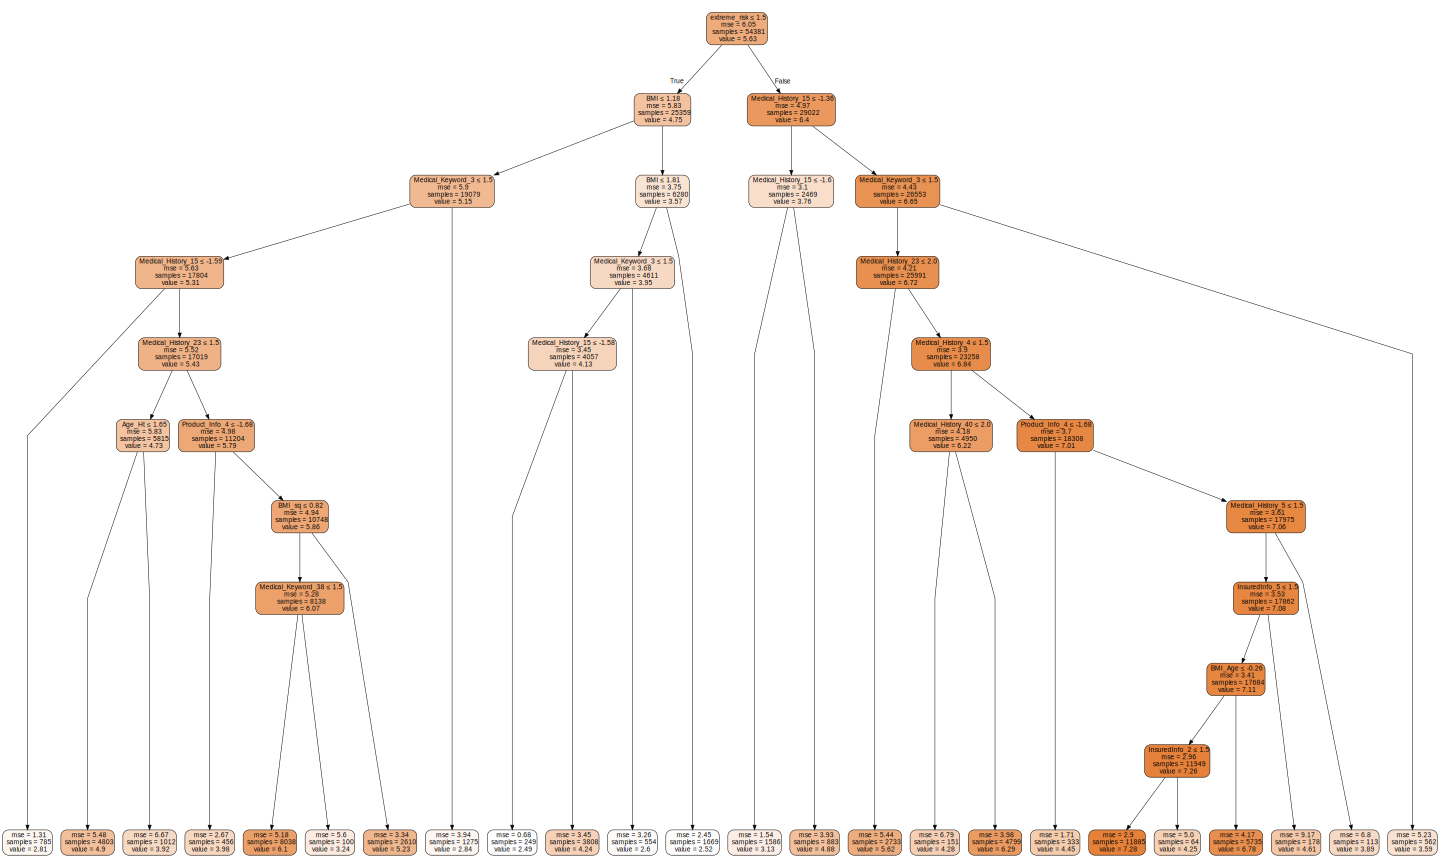

In [27]:
draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

/home/jimbeam/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jimbeam/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


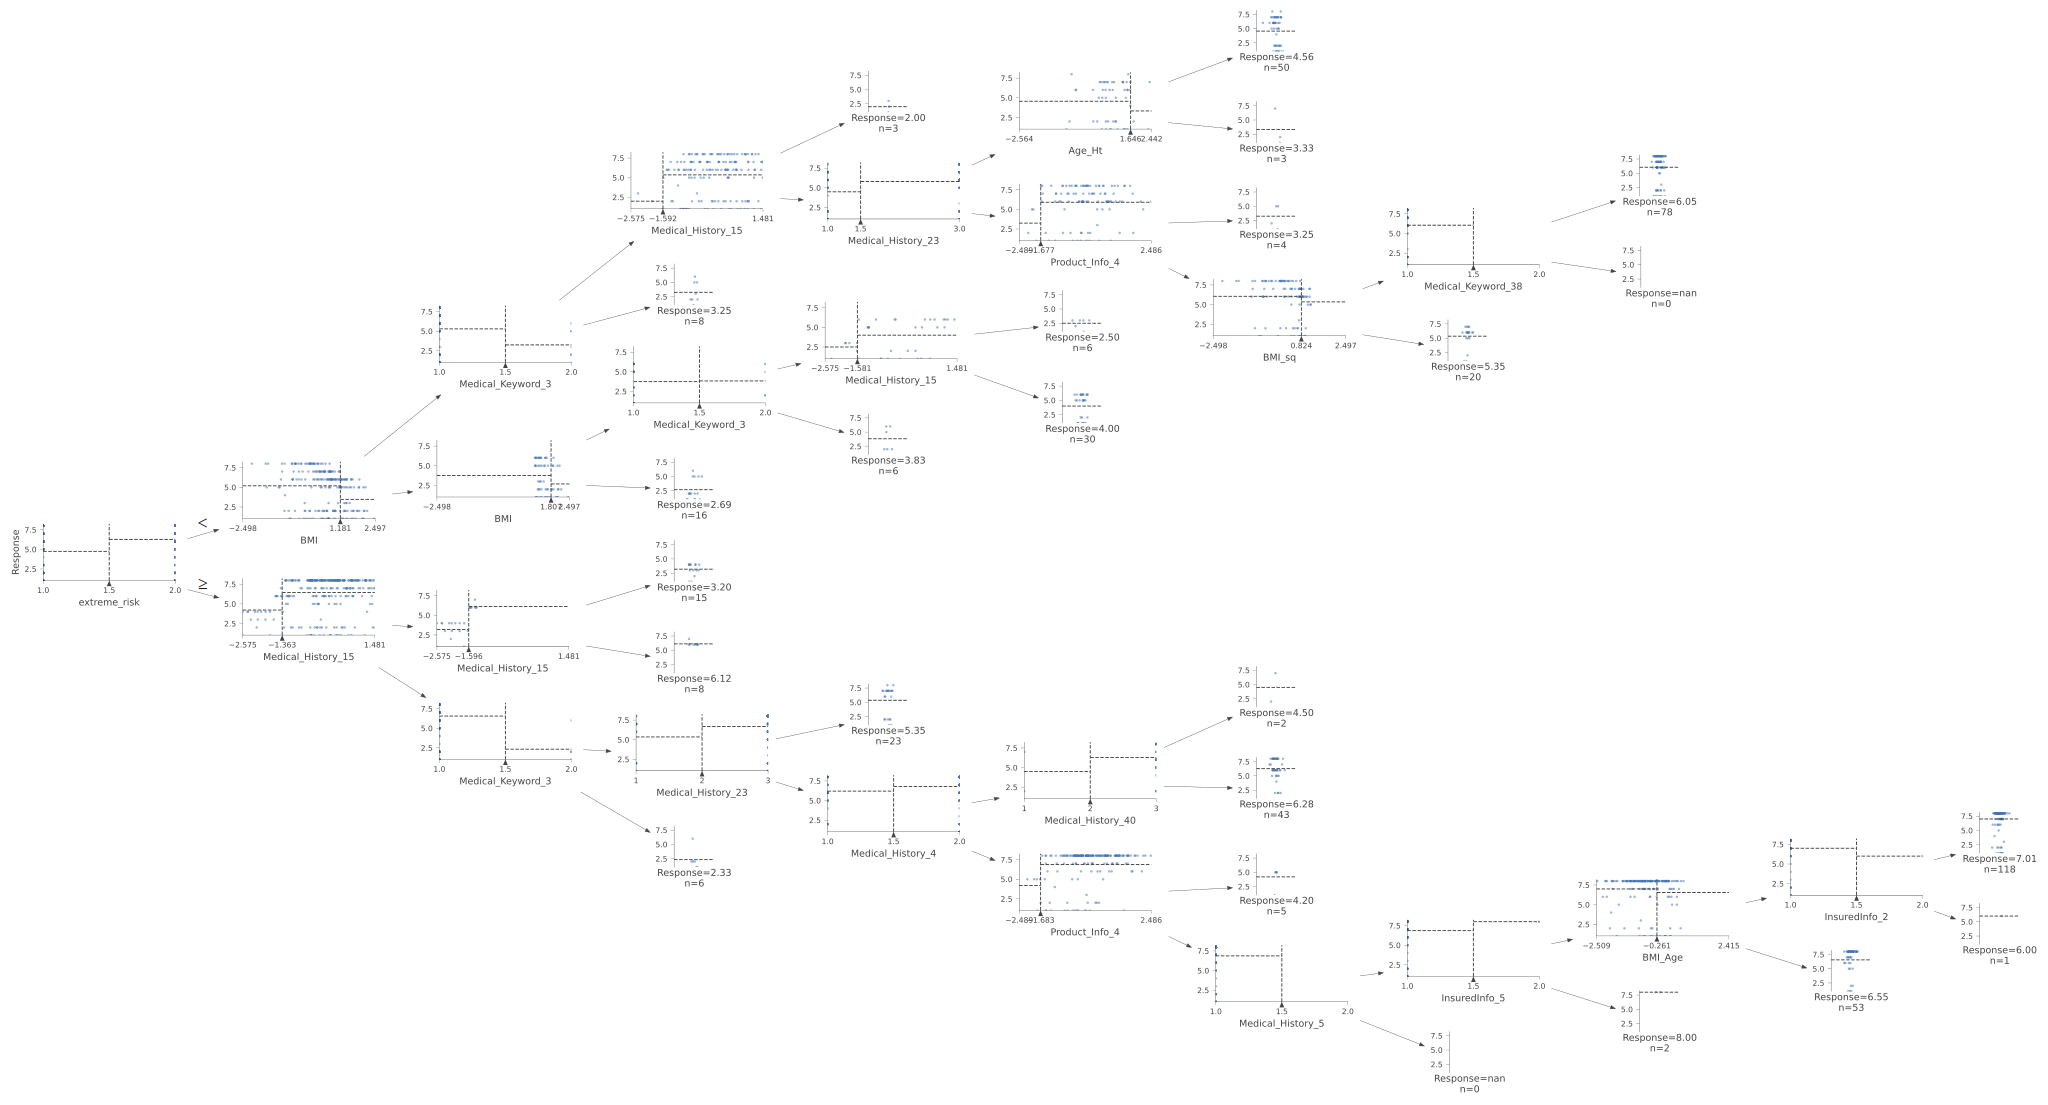

In [28]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [29]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.993082, 1.971465)

In [30]:
m = DecisionTreeRegressor(min_samples_leaf=56)
m.fit(xs, y);

In [31]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.822813, 1.962581)

In [32]:
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.822906, 1.96486)

# Random Forest

In [33]:
m = rf(xs, y, max_samples=52577)

In [34]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(1.246421, 1.884615)

In [35]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [36]:
r_mse(preds.mean(0), valid_y)

1.884615

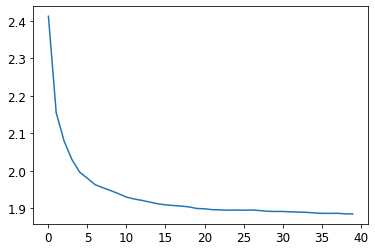

In [37]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [38]:
r_mse(m.oob_prediction_, y)

1.920181

In [39]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
134,Medical_History_15,0.102172
67,extreme_risk,0.066686
123,BMI,0.054631
155,BMI_cu,0.053726
72,Medical_Keyword_3,0.044289
119,Product_Info_4,0.043123
154,BMI_sq,0.040620
43,Medical_History_23,0.033540
26,Medical_History_4,0.026320
132,Medical_History_1,0.021556


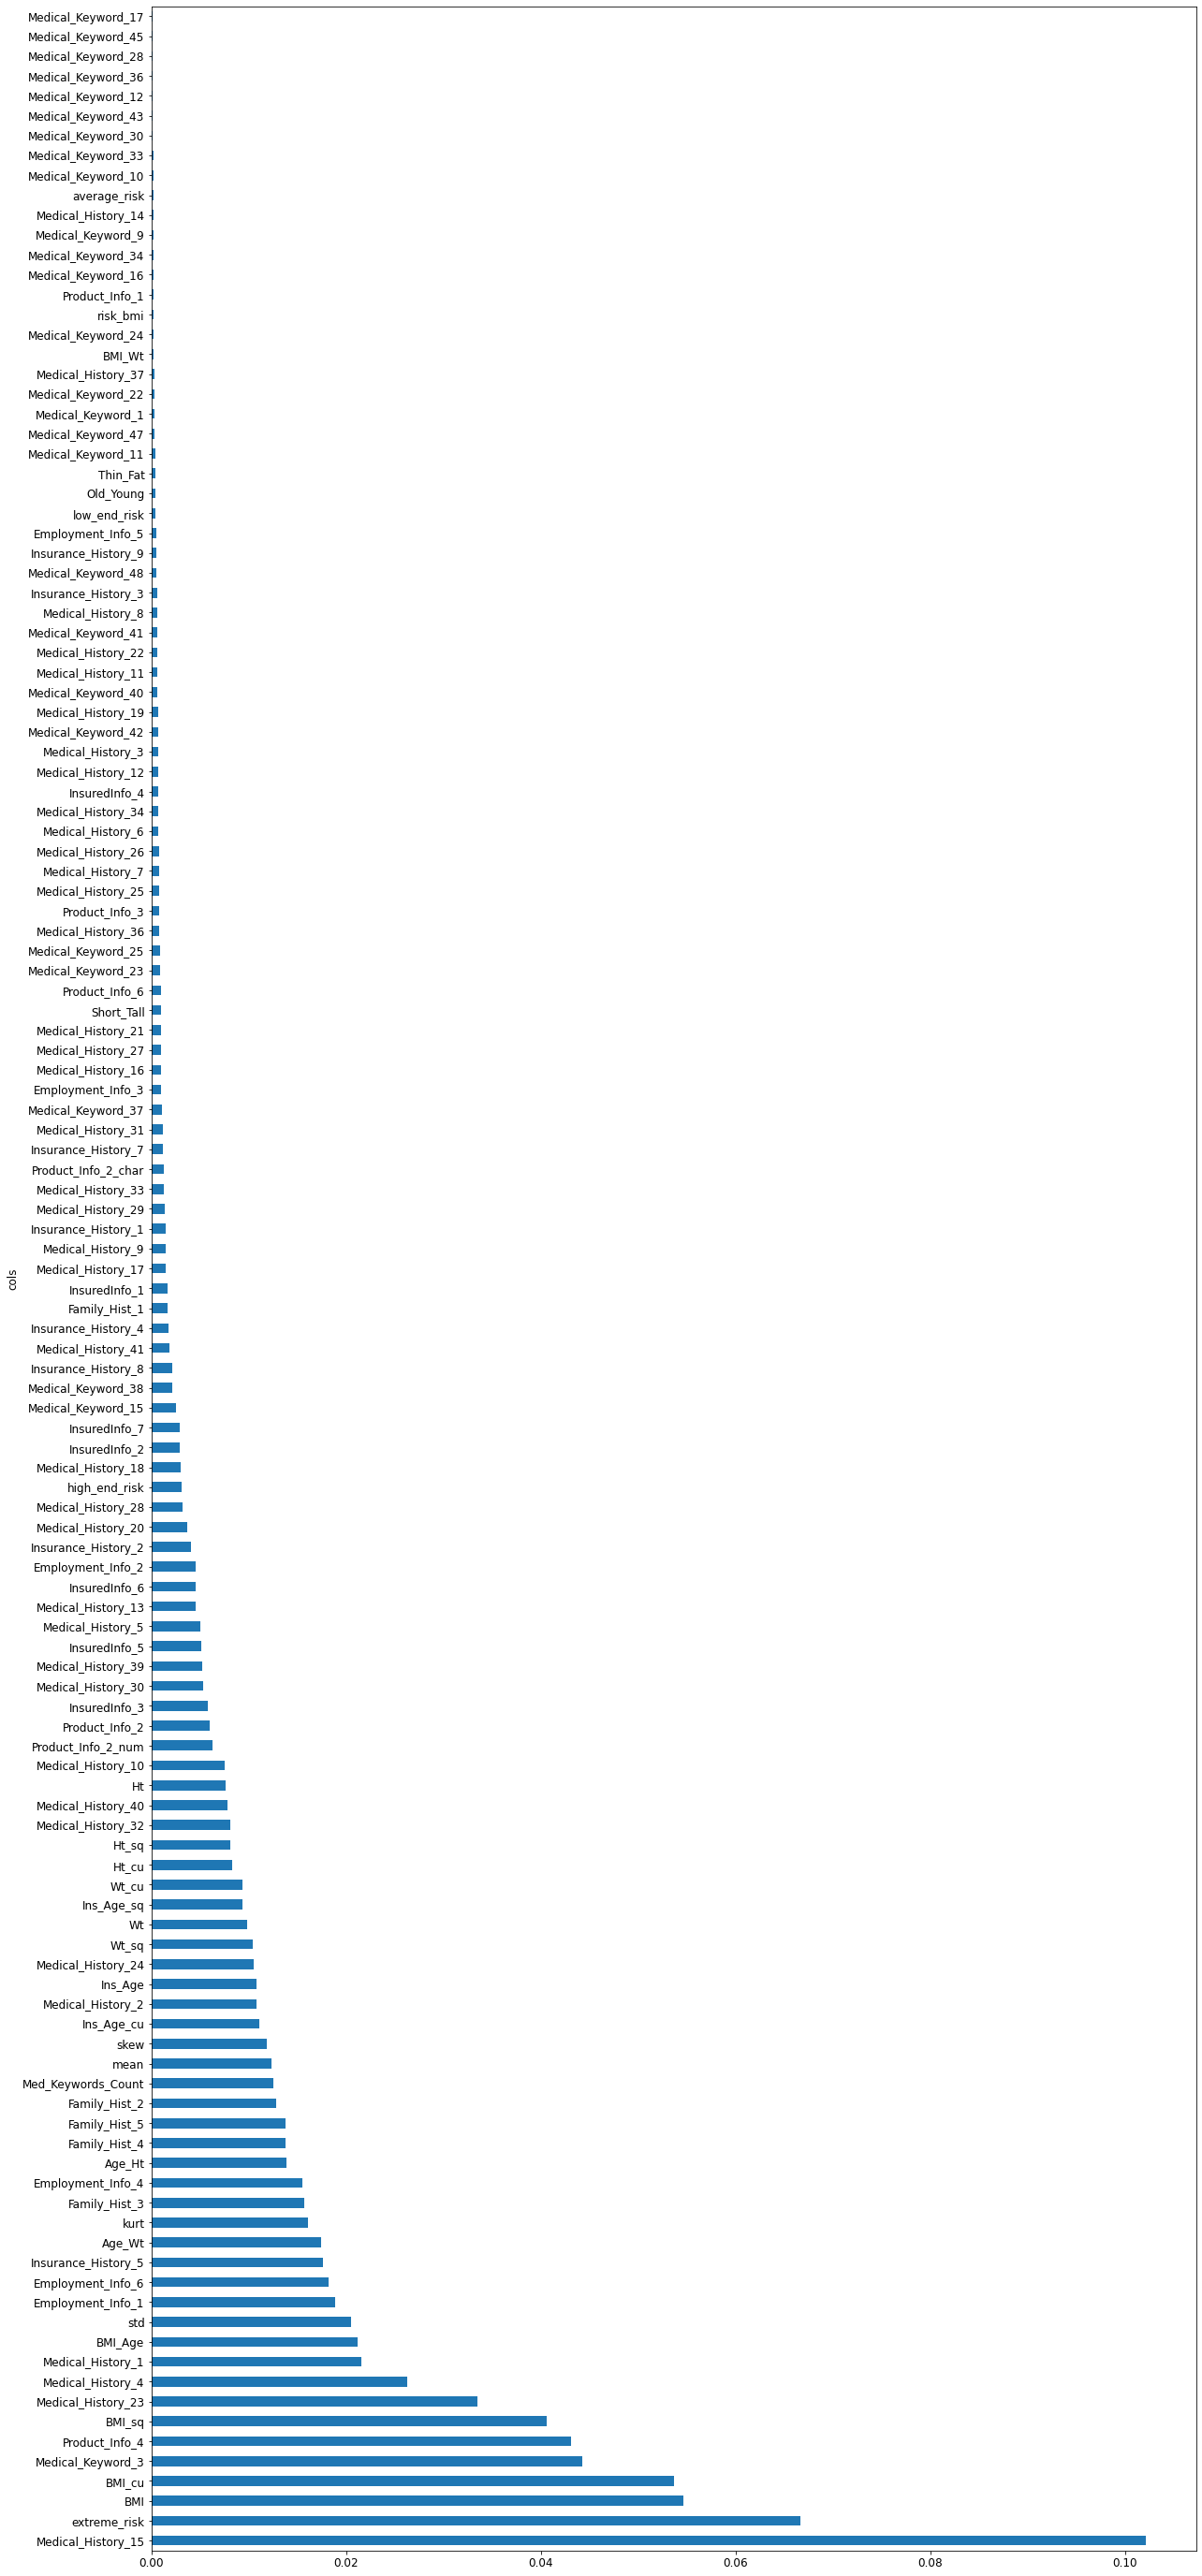

In [40]:
plot_fi(fi[:128], 20, 50);

In [41]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

47

In [42]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y, max_samples=52577)

m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(1.273876, 1.926291)

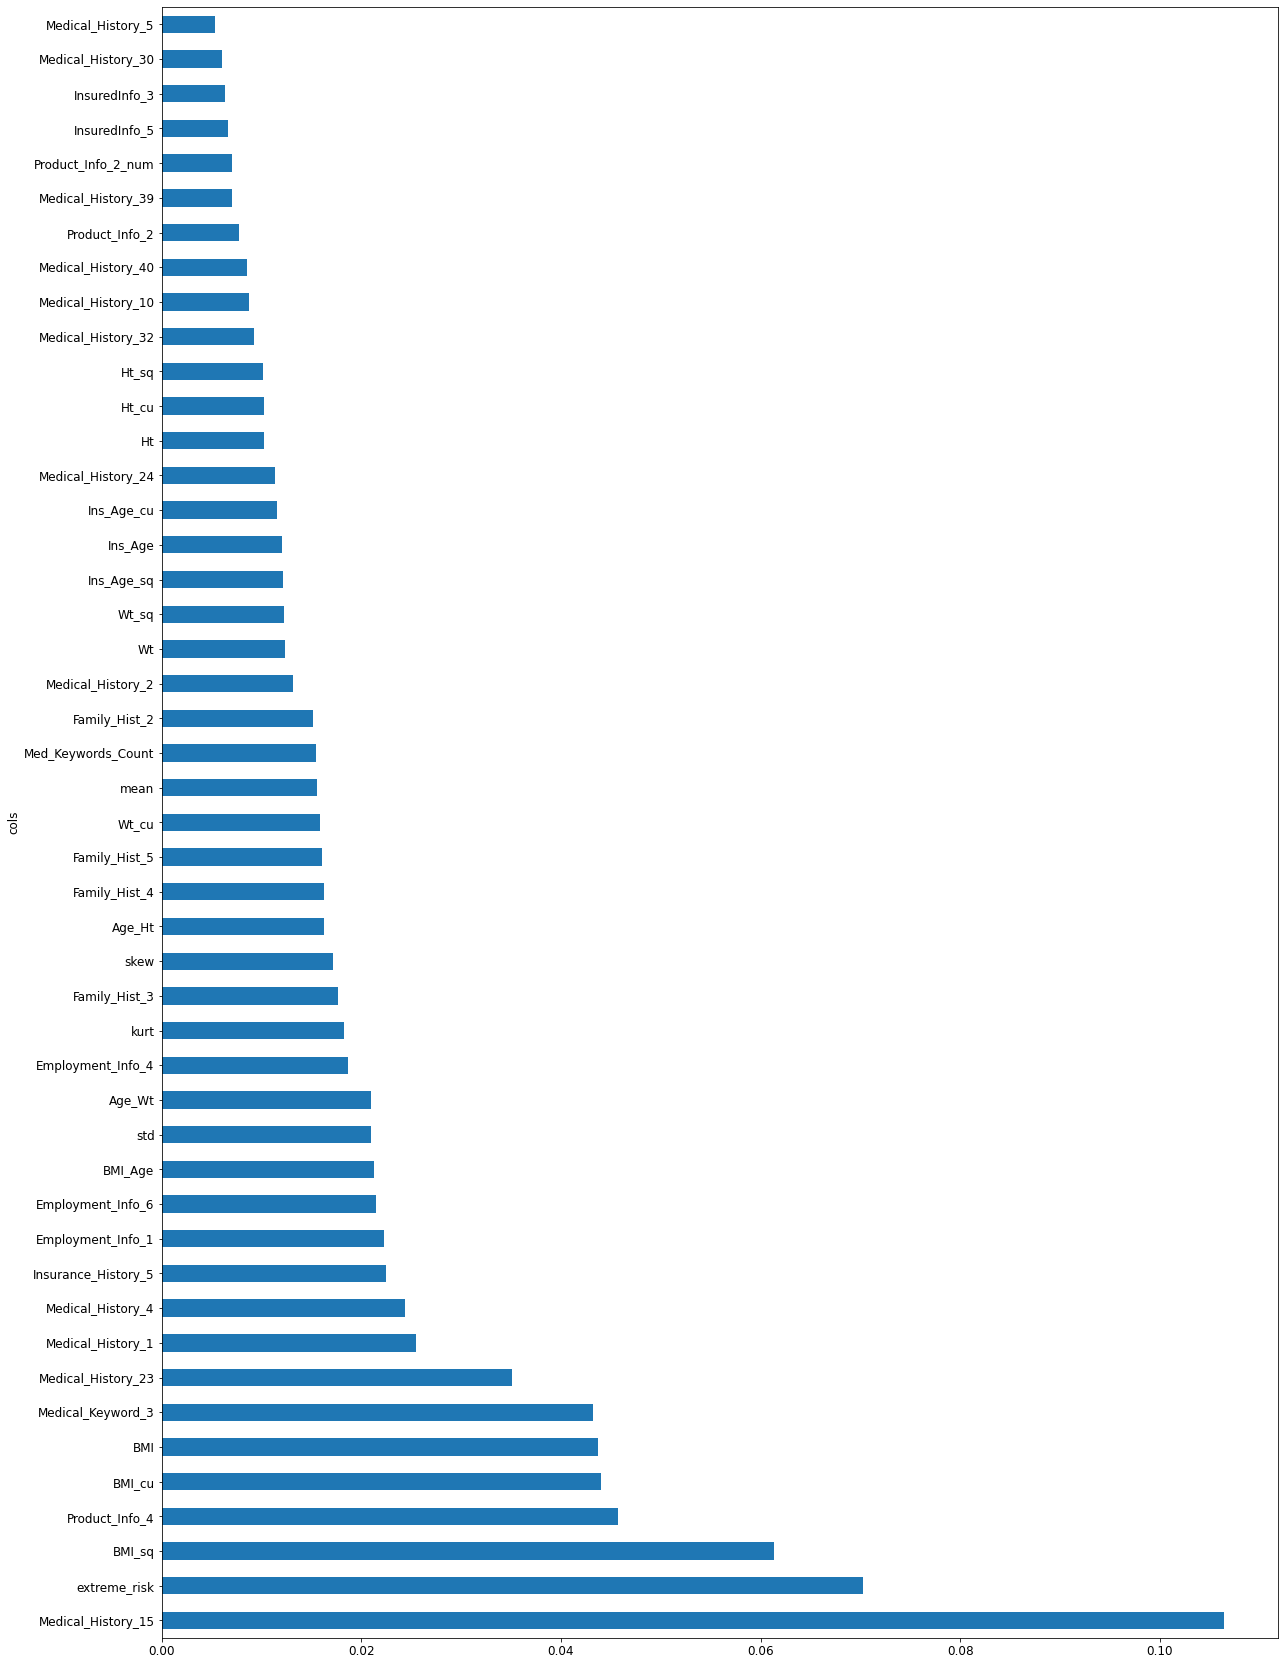

In [43]:
plot_fi(rf_feat_importance(m, xs_imp), 20, 30);

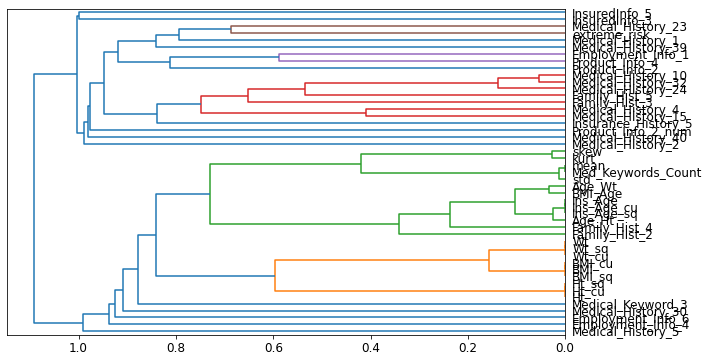

In [44]:
cluster_columns(xs_imp)

In [45]:
get_oob(xs_imp, y, 52577)

0.3778377889976001

In [46]:
save_pickle(modelPath/'xs_imp.pkl', xs_imp)
save_pickle(modelPath/'valid_xs_imp.pkl', valid_xs_imp)

# Train again

In [47]:
xs_final = load_pickle(modelPath/'xs_imp.pkl')
valid_xs_final = load_pickle(modelPath/'valid_xs_imp.pkl')

In [48]:
m = rf(xs_final, y, max_samples = 52577)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(1.275892, 1.932667)

# Neural Network

In [49]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_all, procs_nn, cat, cont,
                      splits=splits, y_names=dep_var)

In [50]:
dls = to_nn.dataloaders(1024)

In [51]:
y = to_nn.train.y
y.min(),y.max()

(1, 8)

In [52]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [53]:
learn.lr_find()

RuntimeError: Found dtype Char but expected Float